In [101]:
#import dependencies
import pandas as pd
import matplotlib as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import sklearn as skl
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report,confusion_matrix
import sklearn.model_selection as model_selection

from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

from sklearn.metrics import accuracy_score

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.ensemble import GradientBoostingClassifier

import psycopg2

In [102]:
from configparser import ConfigParser


def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db


In [105]:
import psycopg2
from config import config

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')


if __name__ == '__main__':
    connect()

ModuleNotFoundError: ignored

In [ ]:
#read in the data
#take input from provisional database (csv)
#df = pd.read_csv(Path('./Resources/all_responses_coded.csv'))
# Load the csv file from GitHub
#url = 'https://raw.githubusercontent.com/mandymccabe/Final_Project/janet_branch/Data/Final_Project_Full.csv'
#url2= 'https://raw.githubusercontent.com/mandymccabe/Final_Project/main/Resources/all_responses_coded.csv'
#df = pd.read_csv(url, index_col=0)
#df2 = pd.read_csv(url2, index_col=0)


#df = pd
#df2 =
df.head(10)


,political_views,trust_in_press,online_paid_access,impression_with_access_to_data,trump_as_president,age,gender,income,us_region,startdate,...,usa_today,washington_post,fox_news,breitbart,cnn,buzzfeed,huffington_post,time,us_news_and_world_report,other
respondentid,,,,,,,,,,,,,,,,,,,,,
6176264298,Moderate,Fair Amount,No,No Change,Strongly Disapprove,30-44,Male,"$10,000-$24,999",East South Central,2017-05-01,...,1,0,0,0,1,0,0,1,0,0
6176263960,Moderate,Fair Amount,No,Increase Trust,Somewhat Disapprove,18-29,Female,"$0-$9,999",Middle Atlantic,2017-05-01,...,0,0,0,0,1,0,0,0,0,0
6176258621,Liberal,Fair Amount,Yes,Increase Trust,Strongly Disapprove,30-44,Male,"$125,000-$149,999",East North Central,2017-05-01,...,0,1,0,0,0,0,0,0,0,BBC
6176257082,Liberal,Fair Amount,No,Increase Trust,Strongly Disapprove,18-29,Male,"$125,000-$149,999",Mountain,2017-05-01,...,0,1,0,0,0,0,0,0,0,"BBC News, and local news outlets"
6176256111,Liberal,Fair Amount,Yes,No Change,Strongly Disapprove,30-44,Male,"$10,000-$24,999",Pacific,2017-05-01,...,1,0,0,0,1,1,0,1,0,0
6176254380,Liberal,Not Very Much,No,Increase Trust,Strongly Disapprove,30-44,Female,"$200,000 & up",Mountain,2017-05-01,...,0,1,0,0,0,0,0,0,0,0
6176253761,Conservative,Not Very Much,No,Increase Trust,Strongly Approve,30-44,Male,"$50,000-$74,999",East North Central,2017-05-01,...,0,0,0,0,0,0,0,0,0,None
6176248227,Moderate,Not Very Much,No,Increase Trust,Somewhat Disapprove,18-29,Male,"$10,000-$24,999",Pacific,2017-05-01,...,0,0,1,0,1,0,0,0,0,0
6176247712,Moderate,Fair Amount,No,Increase Trust,Strongly Disapprove,30-44,Male,"$25,000-$49,999",West North Central,2017-05-01,...,0,0,0,0,0,0,0,0,0,"NPR, Reuters, New Yorker, Al Jazeera English, ..."


In [ ]:
df2.head()

,RespondentID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A55,A56,A57,A58,A59,A60,A61,A62,StartDate,EndDate
index,,,,,,,,,,,,,,,,,,,,,
0,6176264298,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,5/1/17 15:41,5/1/17 15:43
1,6176263960,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,5/1/17 15:35,5/1/17 15:43
2,6176258621,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,5/1/17 15:38,5/1/17 15:40
3,6176257082,0,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,0,5/1/17 15:38,5/1/17 15:39
4,6176256111,0,0,0,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,5/1/17 15:34,5/1/17 15:39


In [ ]:
PoliticalViews = df.filter(["political_views"], axis=1)
PoliticalViews.head()

,political_views
respondentid,
6176264298,Moderate
6176263960,Moderate
6176258621,Liberal
6176257082,Liberal
6176256111,Liberal


In [ ]:
#drop columns we don't want to use to predict and those that do not have an int value

df2 = df2.drop(["A21", "StartDate", "EndDate"], axis=1)
df2.head()

,RespondentID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62
index,,,,,,,,,,,,,,,,,,,,,
0,6176264298,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
1,6176263960,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,6176258621,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,6176257082,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,6176256111,0,0,0,1,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0


In [ ]:
merged_dfs = pd.merge(df2, PoliticalViews, how='outer', left_on=["RespondentID"], right_on=['respondentid'])
#merged_df2 = merged_dfs.drop(['political_views_x'], axis=1)
merged_dfs.head()

,RespondentID,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A54,A55,A56,A57,A58,A59,A60,A61,A62,political_views
0,6176264298,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,Moderate
1,6176263960,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,Moderate
2,6176258621,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,Liberal
3,6176257082,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,Liberal
4,6176256111,0,0,0,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,Liberal


In [ ]:
#merged_df2 = merged_df2.drop(["RespondentID"], axis=1)
#merged_df2.head()

In [ ]:
#set target and x values
X=merged_dfs[list(merged_dfs.columns)[6:-1]]
X.head()

,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,...,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62
0,0,1,0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,1,0,0,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [ ]:
#Y
y=merged_dfs[list(merged_dfs.columns)[-1]]
y.head(10)

0             Moderate
1             Moderate
2              Liberal
3              Liberal
4              Liberal
5              Liberal
6         Conservative
7             Moderate
8             Moderate
9    Very Conservative
Name: political_views, dtype: object

In [ ]:
#split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=3, train_size=0.80)

In [ ]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

Training target statistics: Counter({'Moderate': 334, 'Liberal': 179, 'Conservative': 170, 'Very Liberal': 89, 'Very Conservative': 44})
Testing target statistics: Counter({'Moderate': 86, 'Conservative': 45, 'Liberal': 41, 'Very Liberal': 22, 'Very Conservative': 11})


Decision Tree

In [ ]:
DTC = DecisionTreeClassifier (random_state=3)
DTC.fit(X_train_scaled, y_train)
#the random state of 3 was chosen after trying many different values and finding 3 yielded the best results

DecisionTreeClassifier(random_state=3)

In [ ]:
predictions = DTC.predict(X_test_scaled)

In [ ]:
print("Decision Tree Train Accuracy:", metrics.accuracy_score(y_train, DTC.predict(X_train_scaled)))

Decision Tree Train Accuracy: 0.9975490196078431


In [ ]:
y_pred= DTC.predict(X_test)
print('Accuracy of decision tree classifier on test set: {:.2f}'.format(DTC.score(X_test_scaled, y_test)))

Accuracy of decision tree classifier on test set: 0.39


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

     Conservative       0.44      0.62      0.52        45
          Liberal       0.43      0.37      0.39        41
         Moderate       0.41      0.40      0.40        86
Very Conservative       0.00      0.00      0.00        11
     Very Liberal       0.19      0.18      0.19        22

         accuracy                           0.40       205
        macro avg       0.29      0.31      0.30       205
     weighted avg       0.38      0.40      0.38       205



Try Random Forest Classifier

In [ ]:
#split into training and testing
X_trainRFC, X_testRFC, y_trainRFC, y_testRFC = train_test_split(
    X, y, random_state=3, train_size=0.80)

In [ ]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_trainRFC)

# Scale the data
X_train_scaledRFC = X_scaler.transform(X_trainRFC)
X_test_scaledRFC = X_scaler.transform(X_testRFC)

In [ ]:
# Create a random forest classifier.
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaledRFC, y_trainRFC)

In [ ]:
# Making predictions using the testing data.
predictionsRFC = rf_model.predict(X_test_scaledRFC)

In [ ]:
# Calculating the accuracy score.
acc_scoreRFC = accuracy_score(y_testRFC, predictionsRFC)
print(f"Accuracy of random forest classifier on test set: {acc_scoreRFC}")

Accuracy of random forest classifier on test set: 0.45365853658536587


In [ ]:
print("Classification Report")
print(classification_report(y_testRFC, predictionsRFC))

Classification Report
                   precision    recall  f1-score   support

     Conservative       0.50      0.49      0.49        45
          Liberal       0.41      0.34      0.37        41
         Moderate       0.47      0.63      0.54        86
Very Conservative       0.20      0.09      0.13        11
     Very Liberal       0.29      0.09      0.14        22

         accuracy                           0.45       205
        macro avg       0.37      0.33      0.33       205
     weighted avg       0.43      0.45      0.43       205



In [ ]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_


In [ ]:
# Sort the features by their importance.

importances = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances

[(0.08675610420464612, 'A30'),
 (0.04421384981992817, 'A10'),
 (0.04406785744004773, 'A14'),
 (0.03208900147917653, 'A27'),
 (0.03150949514142913, 'A28'),
 (0.026320232534045605, 'A13'),
 (0.026239306838506754, 'A16'),
 (0.025023512628246588, 'A34'),
 (0.02385777307146355, 'A32'),
 (0.022695727120157487, 'A39'),
 (0.022617460707487852, 'A11'),
 (0.021965096965293595, 'A19'),
 (0.0215256983297897, 'A35'),
 (0.02142464133705761, 'A40'),
 (0.02088626312261106, 'A60'),
 (0.02085318107131397, 'A7'),
 (0.020632470895060203, 'A36'),
 (0.020556285367815712, 'A29'),
 (0.020474946604015134, 'A57'),
 (0.02007518107014657, 'A8'),
 (0.01964406387114024, 'A50'),
 (0.018258325269536115, 'A33'),
 (0.018103403203890416, 'A56'),
 (0.017724227576156437, 'A52'),
 (0.017625158005820096, 'A25'),
 (0.017617824951703286, 'A58'),
 (0.01688387807803829, 'A49'),
 (0.01658751045449575, 'A12'),
 (0.015853101189711262, 'A20'),
 (0.015337409029457984, 'A23'),
 (0.015128884965862944, 'A47'),
 (0.014817287273535542, '

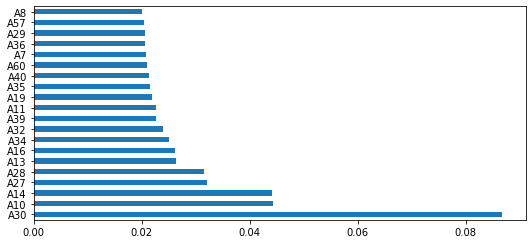

In [ ]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
classifier = GradientBoostingClassifier(n_estimators=20,
   learning_rate=0.5, max_features=5, max_depth=3, random_state=0)

classifier.fit(X_train_scaledRFC, y_trainRFC)
predictions_boost = classifier.predict(X_test_scaledRFC)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
acc_score_boost = accuracy_score(y_testRFC, predictions_boost)
print(f"Accuracy Score RFC after boosting : {acc_score_boost}")

Accuracy Score RFC after boosting : 0.4585365853658537


In [ ]:
print("Classification Report")
print(classification_report(y_testRFC, predictions_boost))

Classification Report
                   precision    recall  f1-score   support

     Conservative       0.54      0.58      0.56        45
          Liberal       0.36      0.39      0.38        41
         Moderate       0.49      0.55      0.52        86
Very Conservative       0.20      0.09      0.13        11
     Very Liberal       0.33      0.18      0.24        22

         accuracy                           0.46       205
        macro avg       0.39      0.36      0.36       205
     weighted avg       0.44      0.46      0.45       205



#accuracy is very poor for 5 outputs, will combine very conservative/conservative and very liberal/liberal respondents to condense to 3 output options

In [ ]:
PoliticalViews3 = PoliticalViews.replace(regex={r'Very Conservative': 'Conservative', 'Very Liberal': 'Liberal'})
PoliticalViews3.head(10)

,political_views
respondentid,
6176264298,Moderate
6176263960,Moderate
6176258621,Liberal
6176257082,Liberal
6176256111,Liberal
6176254380,Liberal
6176253761,Conservative
6176248227,Moderate
6176247712,Moderate


In [ ]:
PoliticalnumViews = PoliticalViews3.replace(regex={r'Conservative': '1', 'Moderate': '2', 'Liberal':'3'})
PoliticalnumViews.head()

,political_views
respondentid,
6176264298,2
6176263960,2
6176258621,3
6176257082,3
6176256111,3


In [ ]:
#create dummy variables for multiclass predictor
PoliticalnumViews = pd.get_dummies(PoliticalnumViews["political_views"])
#PoliticalViews = PoliticalViews.drop(["Very 3"], axis=1)
PoliticalnumViews.head(10)

,1,2,3
respondentid,,,
6176264298,0,1,0
6176263960,0,1,0
6176258621,0,0,1
6176257082,0,0,1
6176256111,0,0,1
6176254380,0,0,1
6176253761,1,0,0
6176248227,0,1,0
6176247712,0,1,0


In [ ]:
df3 = df2.drop(["A1", "A2", "A3", "A4", "A5"], axis=1)
df3.head()


,RespondentID,A6,A7,A8,A9,A10,A11,A12,A13,A14,...,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62
index,,,,,,,,,,,,,,,,,,,,,
0,6176264298,0,1,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
1,6176263960,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,6176258621,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,6176257082,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
4,6176256111,0,1,0,0,1,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0


In [ ]:
df3 = pd.merge(df3, PoliticalnumViews, how='outer', left_on=["RespondentID"], right_on=['respondentid'])
df3 = pd.merge(df3, PoliticalViews3, how='outer', left_on=["RespondentID"], right_on=['respondentid'])
df3 = df3.drop(['RespondentID'], axis=1)
df3.head(10)

,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,...,A57,A58,A59,A60,A61,A62,1,2,3,political_views
0,0,1,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,Moderate
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,Moderate
2,0,1,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,Liberal
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,Liberal
4,0,1,0,0,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,Liberal
5,0,0,1,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,Liberal
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,Conservative
7,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,Moderate
8,0,1,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,Moderate
9,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,Conservative


In [ ]:
# set target data  and x values
X3=df3[list(df3.columns)[:-4]]
print(X.shape)
X3.head()

(1021, 56)


,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,...,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62
0,0,1,0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,1,0,0,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [ ]:
#Y
y3=df3[list(df3.columns)[-1]]
y3.head(10)

0        Moderate
1        Moderate
2         Liberal
3         Liberal
4         Liberal
5         Liberal
6    Conservative
7        Moderate
8        Moderate
9    Conservative
Name: political_views, dtype: object

In [ ]:
#split into training and testing
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, random_state=3, train_size=0.80)

In [ ]:
# summarize class distribution
print('Training target statistics with 3 outputs: {}'.format(Counter(y3_train)))
print('Testing target statistics with 3 outputs: {}'.format(Counter(y3_test)))

Training target statistics with 3 outputs: Counter({'Moderate': 334, 'Liberal': 268, 'Conservative': 214})
Testing target statistics with 3 outputs: Counter({'Moderate': 86, 'Liberal': 63, 'Conservative': 56})


In [ ]:
#Decision Tree for set of 3
DTC3 = DecisionTreeClassifier(random_state=3)
DTC3.fit(X3_train, y3_train)

DecisionTreeClassifier(random_state=3)

In [ ]:
predictions3 = DTC3.predict(X3_test)

In [ ]:
y3_pred= DTC3.predict(X3_test)
print ("Decision Tree Train Accuracy on 3 outputs:", metrics.accuracy_score(y3_train, DTC3.predict(X3_train)))
print('Accuracy of decision tree classifier on test set for 3 outputs: {:.2f}'.format(DTC3.score(X3_test, y3_test)))

Decision Tree Train Accuracy on 3 outputs: 0.9975490196078431
Accuracy of decision tree classifier on test set for 3 outputs: 0.47


In [ ]:
print(classification_report(y3_test, y3_pred))

              precision    recall  f1-score   support

Conservative       0.56      0.48      0.52        56
     Liberal       0.47      0.49      0.48        63
    Moderate       0.42      0.44      0.43        86

    accuracy                           0.47       205
   macro avg       0.48      0.47      0.48       205
weighted avg       0.47      0.47      0.47       205



Random Forest Classifier

In [ ]:
#split into training and testing
X3_trainRFC, X3_testRFC, y3_trainRFC, y3_testRFC = train_test_split(
    X3, y3, random_state=3, train_size=0.80)

# Fit the StandardScaler
X3_scaler = scaler.fit(X3_trainRFC)

# Scale the data
X3_train_scaledRFC = X3_scaler.transform(X3_trainRFC)
X3_test_scaledRFC = X3_scaler.transform(X3_testRFC)

# Fitting the model
rf_model3 = rf_model.fit(X3_train_scaledRFC, y3_trainRFC)

# Making predictions using the testing data.
predictions3RFC = rf_model.predict(X3_test_scaledRFC)

# Calculating the accuracy score.
acc_score3RFC = accuracy_score(y3_testRFC, predictions3RFC)
print(f"Accuracy of random forest classifier on test set with 3 outputs: {acc_score3RFC}")

print("Classification Report")
print(classification_report(y3_testRFC, predictions3RFC))

classifier.fit(X3_train_scaledRFC, y3_trainRFC)
predictions3_boost = classifier.predict(X3_test_scaledRFC)

acc_score3_boost = accuracy_score(y3_testRFC, predictions3_boost)
print(f"Accuracy Score RFC after boosting with 3 outputs: {acc_score3_boost}")

print("Classification Report")
print(classification_report(y3_testRFC, predictions3_boost))

Accuracy of random forest classifier on test set with 3 outputs: 0.5756097560975609
Classification Report
              precision    recall  f1-score   support

Conservative       0.69      0.68      0.68        56
     Liberal       0.56      0.60      0.58        63
    Moderate       0.51      0.49      0.50        86

    accuracy                           0.58       205
   macro avg       0.59      0.59      0.59       205
weighted avg       0.58      0.58      0.58       205

Accuracy Score RFC after boosting with 3 outputs: 0.5658536585365853
Classification Report
              precision    recall  f1-score   support

Conservative       0.65      0.64      0.65        56
     Liberal       0.55      0.63      0.59        63
    Moderate       0.52      0.47      0.49        86

    accuracy                           0.57       205
   macro avg       0.57      0.58      0.58       205
weighted avg       0.57      0.57      0.56       205



Undersampling

In [ ]:
#split into training and testing
X3_train_under, X3_test_under, y3_train_under, y3_test_under = train_test_split(
    X3, y3, random_state=3)

In [ ]:
# summarize class distribution
print("Before undersampling: ", Counter(y3_train_under))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X3_train_under, y3_train_under = undersample.fit_resample(X3_train_under, y3_train_under)

# summarize class distribution
print("After undersampling: ", Counter(y3_train_under))

Before undersampling:  Counter({'Moderate': 316, 'Liberal': 245, 'Conservative': 204})
After undersampling:  Counter({'Liberal': 245, 'Conservative': 204, 'Moderate': 204})


In [ ]:
# Fit the StandardScaler
X3_scaler_under = scaler.fit(X3_train_under)

# Scale the data
X3_train_scaled_under = X3_scaler_under.transform(X3_train_under)
X3_test_scaled_under = X3_scaler_under.transform(X3_test_under)

# Fitting the model
rf_model3_under = rf_model.fit(X3_train_scaled_under, y3_train_under)

# Making predictions using the testing data.
predictions3_under = rf_model.predict(X3_test_scaled_under)

# Calculating the accuracy score.
acc_score3_under = accuracy_score(y3_test_under, predictions3_under)
print(f"Accuracy of random forest classifier on test set with 3 outputs and undersampling: {acc_score3_under}")

print("Classification Report")
print(classification_report(y3_test_under, predictions3_under))

classifier.fit(X3_train_scaled_under, y3_train_under)
predictions3_boost_under = classifier.predict(X3_test_scaled_under)

acc_score3_boost_under = accuracy_score(y3_test_under, predictions3_boost_under)
print(f"Accuracy Score RFC after boosting with 3 outputs and undersampling: {acc_score3_boost_under}")

print("Classification Report")
print(classification_report(y3_test_under, predictions3_boost_under))

Accuracy of random forest classifier on test set with 3 outputs and undersampling: 0.54296875
Classification Report
              precision    recall  f1-score   support

Conservative       0.59      0.74      0.66        66
     Liberal       0.54      0.70      0.61        86
    Moderate       0.49      0.29      0.36       104

    accuracy                           0.54       256
   macro avg       0.54      0.58      0.54       256
weighted avg       0.53      0.54      0.52       256

Accuracy Score RFC after boosting with 3 outputs and undersampling: 0.57421875
Classification Report
              precision    recall  f1-score   support

Conservative       0.61      0.76      0.68        66
     Liberal       0.57      0.85      0.68        86
    Moderate       0.53      0.23      0.32       104

    accuracy                           0.57       256
   macro avg       0.57      0.61      0.56       256
weighted avg       0.56      0.57      0.53       256



Over Sampling

In [ ]:
#split into training and testing
X3_train_over, X3_test_over, y3_train_over, y3_test_over = train_test_split(
    X3, y3, random_state=3)

In [ ]:

# import SMOTE oversampling and other necessary libraries 
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# summarize class distribution
print("Before oversampling: ",Counter(y3_train_over))

# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
X3_train_SMOTE, y3_train_SMOTE = SMOTE.fit_resample(X3_train_over, y3_train_over)

# summarize class distribution
print("After oversampling: ",Counter(y3_train_SMOTE))

Before oversampling:  Counter({'Moderate': 316, 'Liberal': 245, 'Conservative': 204})
After oversampling:  Counter({'Conservative': 316, 'Liberal': 316, 'Moderate': 316})


In [ ]:
# Fit the StandardScaler
X3_scaler_over = scaler.fit(X3_train_SMOTE)

# Scale the data
X3_train_scaled_SMOTE = X3_scaler_over.transform(X3_train_SMOTE)
X3_test_scaled_over = X3_scaler_over.transform(X3_test_over)

# Fitting the model
rf_model3_over = rf_model.fit(X3_train_scaled_SMOTE, y3_train_SMOTE)

# Making predictions using the testing data.
predictions3_over = rf_model.predict(X3_test_scaled_over)

# Calculating the accuracy score.
acc_score3_over = accuracy_score(y3_test_over, predictions3_over)
print(f"Accuracy of random forest classifier on test set with 3 outputs and oversampling: {acc_score3_over}")

print("Classification Report")
print(classification_report(y3_test_over, predictions3_over))

classifier.fit(X3_train_scaled_SMOTE, y3_train_SMOTE)
predictions3_boost_over = classifier.predict(X3_test_scaled_over)

acc_score3_boost_over = accuracy_score(y3_test_over, predictions3_boost_over)
print(f"Accuracy Score RFC after boosting with 3 outputs and oversampling: {acc_score3_boost_over}")

print("Classification Report")
print(classification_report(y3_test_over, predictions3_boost_over))

Accuracy of random forest classifier on test set with 3 outputs and oversampling: 0.58984375
Classification Report
              precision    recall  f1-score   support

Conservative       0.64      0.73      0.68        66
     Liberal       0.59      0.66      0.62        86
    Moderate       0.55      0.44      0.49       104

    accuracy                           0.59       256
   macro avg       0.59      0.61      0.60       256
weighted avg       0.58      0.59      0.58       256

Accuracy Score RFC after boosting with 3 outputs and oversampling: 0.57421875
Classification Report
              precision    recall  f1-score   support

Conservative       0.60      0.67      0.63        66
     Liberal       0.60      0.71      0.65        86
    Moderate       0.51      0.40      0.45       104

    accuracy                           0.57       256
   macro avg       0.57      0.59      0.58       256
weighted avg       0.57      0.57      0.57       256



Decision Tree Classifier Graphic


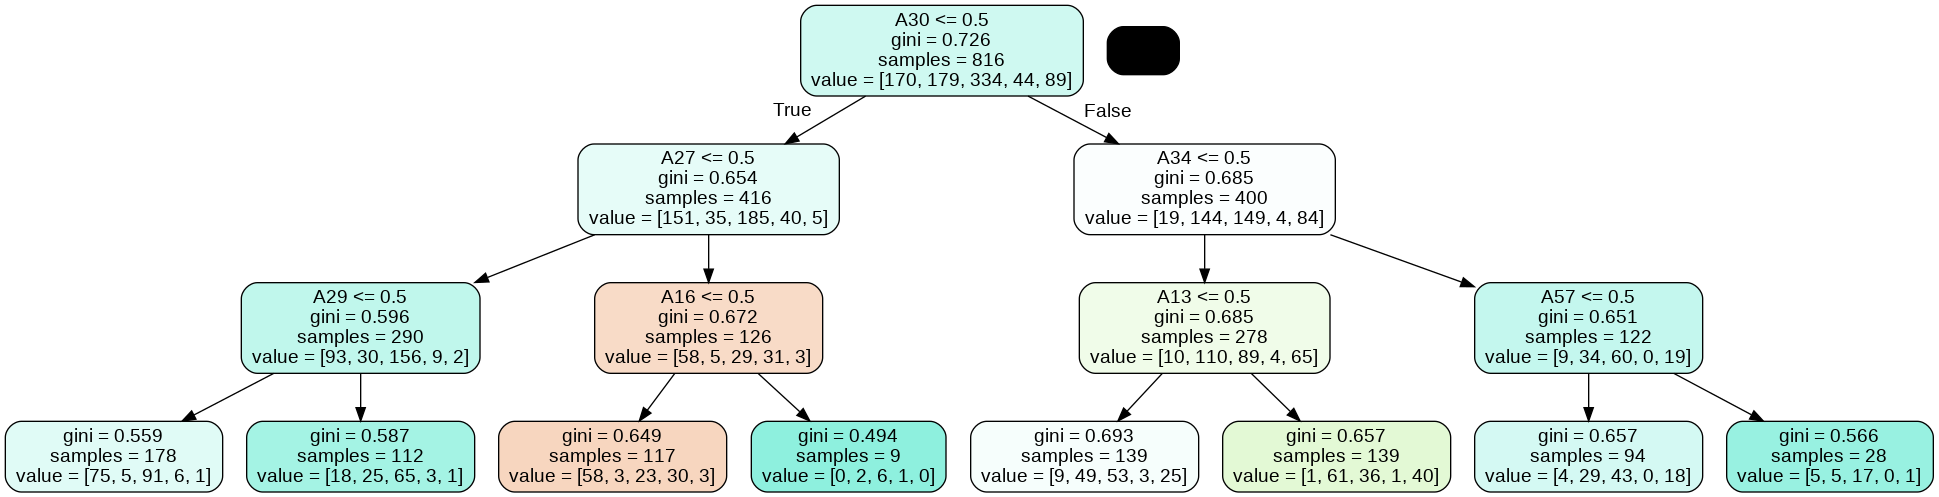

In [ ]:
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

feature_list = list(df3.columns)[:-4]

features = list(feature_list)

DTC_baseline = DecisionTreeClassifier(max_depth=3, random_state=3)
DTC_baseline.fit(X_train,y_train)

dot_data = StringIO()  
export_graphviz(DTC_baseline, out_file=dot_data,feature_names=features,filled=True,rounded=True)
 
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())
